In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
customer = pd.read_csv("/content/drive/MyDrive/Zeotap/Customers.csv")
product = pd.read_csv("/content/drive/MyDrive/Zeotap/Products.csv")
transaction = pd.read_csv("/content/drive/MyDrive/Zeotap/Transactions.csv")

In [31]:
customer.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [32]:
product.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [40]:
transaction.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,ProductCategory_x,ProductCategory_y,ProductCategory
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Electronics,Electronics,Electronics
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Electronics,Electronics,Electronics
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Electronics,Electronics,Electronics
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Electronics,Electronics,Electronics
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Electronics,Electronics,Electronics


# Data Preparation

In [41]:
# Convert dates to datetime objects
customer['SignupDate'] = pd.to_datetime(customer['SignupDate'])
transaction['TransactionDate'] = pd.to_datetime(transaction['TransactionDate'])

# Aggregate transaction data by customer
customer_transactions = transaction.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).rename(columns={'TotalValue': 'Total_Spend', 'Quantity': 'Total_Quantity'})

# Join the dataframes
customer_data = customer.merge(customer_transactions, on='CustomerID', how='left')

# Feature Engineering

In [42]:
# Handling categorical data
customer_data['Region'] = pd.Categorical(customer_data['Region']).codes

# Fill NaN values for customers without transactions
customer_data.fillna({'Total_Spend': 0, 'Total_Quantity': 0}, inplace=True)



In [45]:
# Calculate purchase frequency and diversity of product categories
transaction = transaction[['TransactionID', 'CustomerID', 'ProductID', 'Quantity', 'TotalValue', 'TransactionDate', 'ProductCategory']]
# Add this line only if 'ProductCategory' is not already in 'transaction'
if 'ProductCategory' not in transaction.columns:
    transaction = transaction.merge(product[['ProductID', 'Category']].rename(columns={'Category': 'ProductCategory'}), on='ProductID', how='left')
transaction.info()
customer_freq = transaction.groupby('CustomerID').size().rename('Purchase_Frequency')
product_diversity = transaction.groupby('CustomerID')['ProductCategory'].nunique().rename('Product_Diversity')

# Join these new features with your customer_data dataframe
customer_data = customer_data.join(customer_freq, on='CustomerID')
customer_data = customer_data.join(product_diversity, on='CustomerID')

# Correctly fill NaN values to avoid future warnings and ensure compatibility
customer_data['Purchase_Frequency'] = customer_data['Purchase_Frequency'].fillna(0)
customer_data['Product_Diversity'] = customer_data['Product_Diversity'].fillna(0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   Quantity         1000 non-null   int64         
 4   TotalValue       1000 non-null   float64       
 5   TransactionDate  1000 non-null   datetime64[ns]
 6   ProductCategory  1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 54.8+ KB


# Clustering

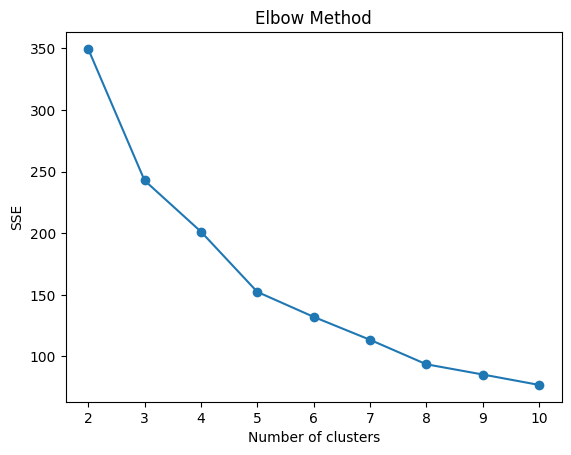

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scaling data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[['Region', 'Total_Spend', 'Total_Quantity']])

# Elbow method to find the optimal number of clusters
import matplotlib.pyplot as plt

sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()


In [47]:
from sklearn.metrics import davies_bouldin_score

# Assuming 'cluster_labels' is defined after fitting KMeans as shown in your notebook
cluster_labels = kmeans.fit_predict(scaled_features)
db_index = davies_bouldin_score(scaled_features, cluster_labels)
print("Davies-Bouldin Index:", db_index)


Davies-Bouldin Index: 0.9340783688392371


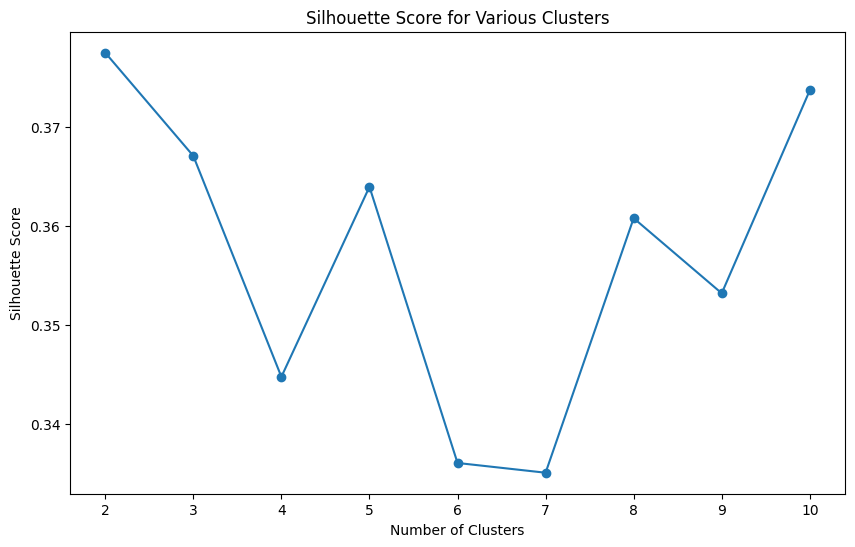

In [48]:
from sklearn.metrics import silhouette_score

# Initialize lists to store the silhouette scores for each k
silhouette_scores = []

# Loop over a range of k values to compute the silhouette score for each
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Various Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


# Visualize the Clusters

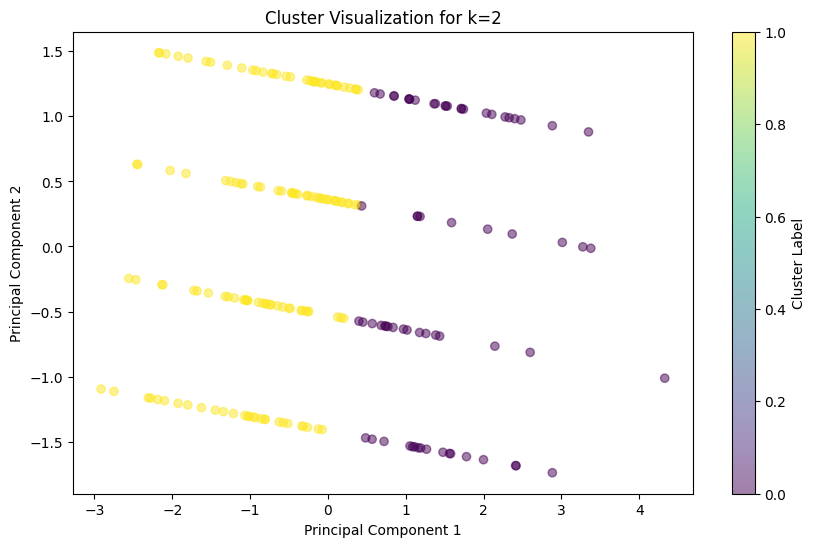

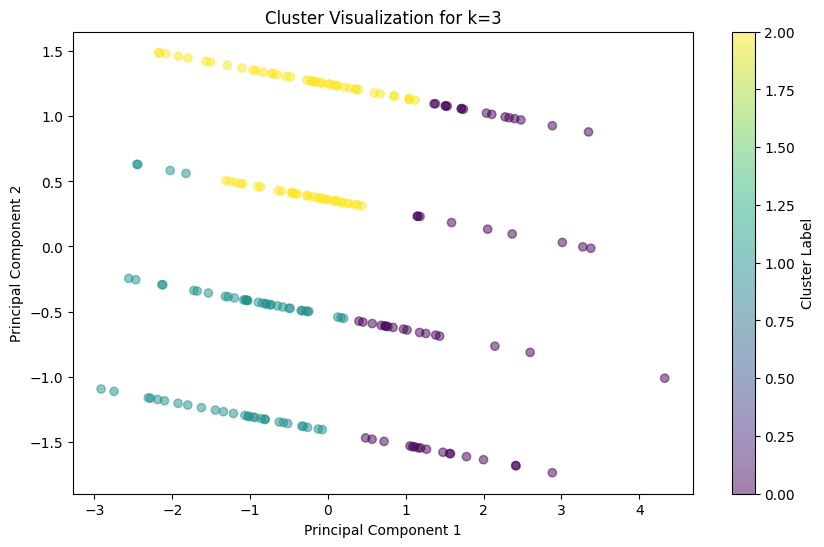

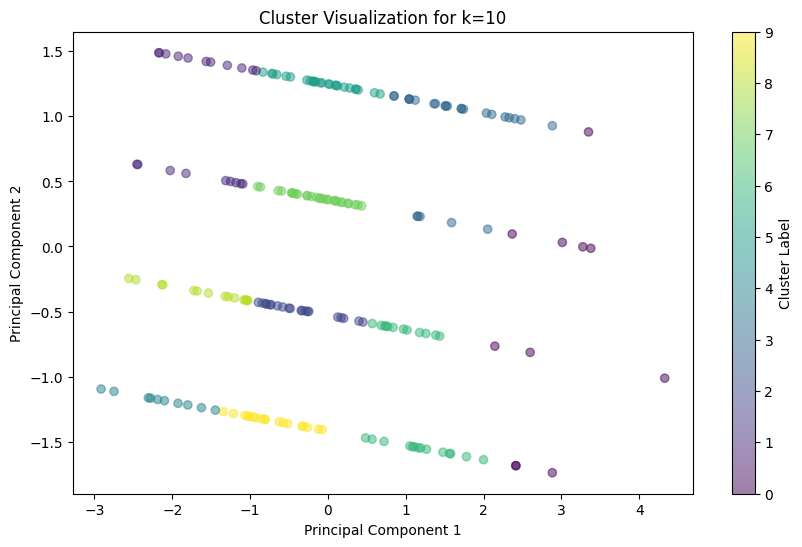

In [50]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Scaling data - assuming scaled_features is already defined
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[['Region', 'Total_Spend', 'Total_Quantity']])

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

def plot_clusters(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_result)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title(f'Cluster Visualization for k={n_clusters}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

# Visualizing for k = 2, 3, 10
plot_clusters(2)
plot_clusters(3)
plot_clusters(10)


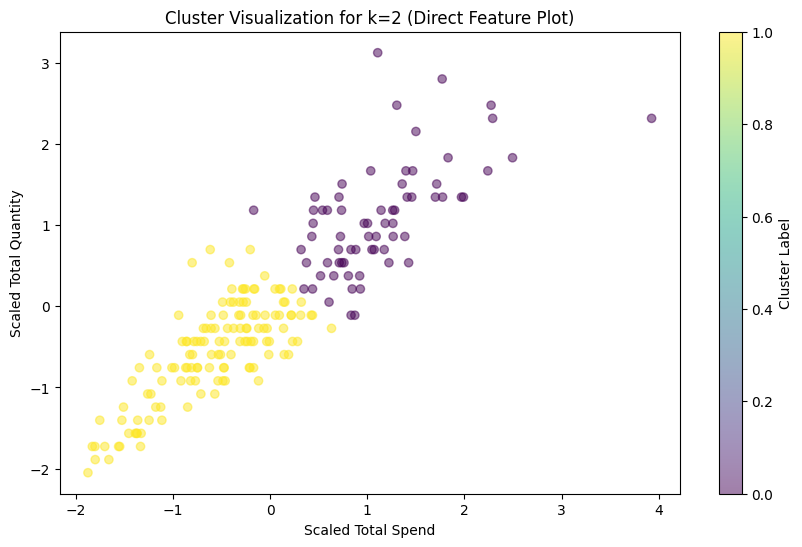

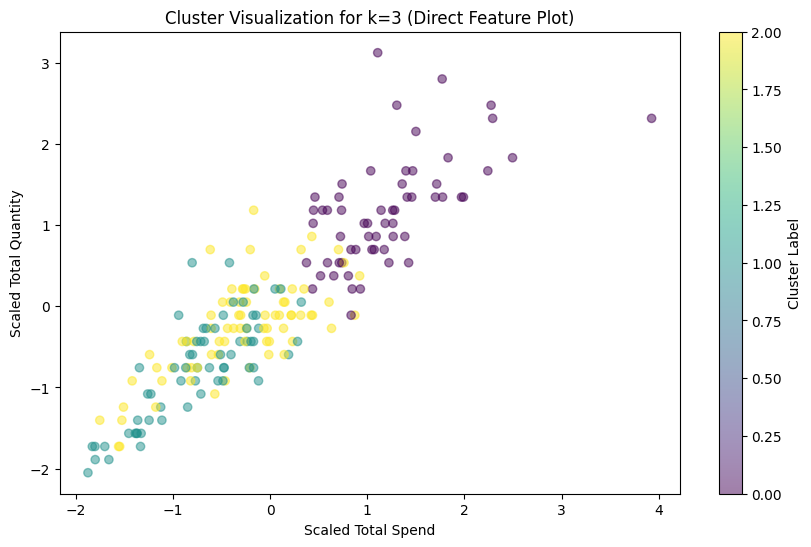

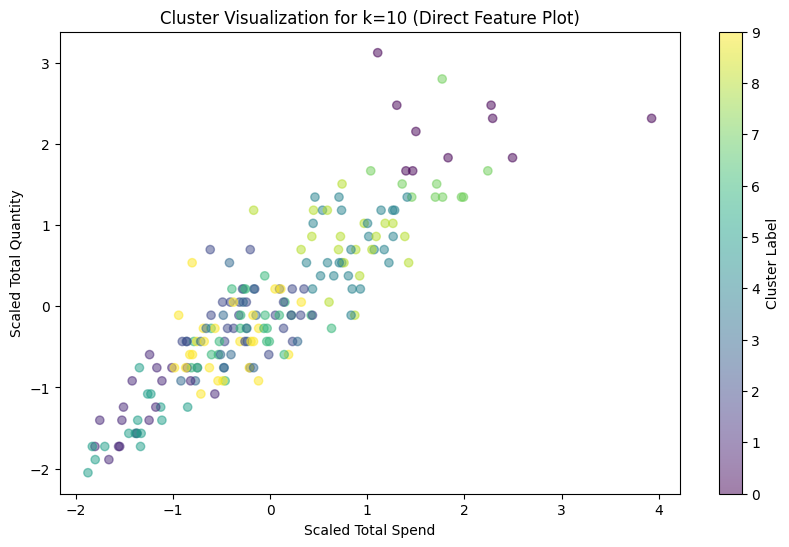

In [51]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Scaling data - assuming scaled_features is already defined
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[['Region', 'Total_Spend', 'Total_Quantity']])
total_spend_scaled = scaled_features[:, 1]  # Assuming Total_Spend is the second feature
total_quantity_scaled = scaled_features[:, 2]  # Assuming Total_Quantity is the third feature

def plot_clusters_directly(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(total_spend_scaled, total_quantity_scaled, c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title(f'Cluster Visualization for k={n_clusters} (Direct Feature Plot)')
    plt.xlabel('Scaled Total Spend')
    plt.ylabel('Scaled Total Quantity')
    plt.colorbar(label='Cluster Label')
    plt.show()

# Visualizing for k = 2, 3, and 10
plot_clusters_directly(2)
plot_clusters_directly(3)
plot_clusters_directly(10)
